# Fingerprint duplication analysis
## Hypothesis
- different molecules (=different inchikey14) should ideally have different fingerprints --> so we search for duplicate fingerprints
- particularly "bad": identical fingerprints for very different molecules. Since we cannot easily measure this without applying a reference score, we here simply use mass difference as an indicator (large mass difference should mean that they cannot be too similar, the opposite is not true though)

Data:

Compare multiple fingerprints on the "biomolecular structures" dataset (Fleming 2024, 718,067 compounds)
- Biomolecules dataset from Fleming et al. --> https://github.com/boecker-lab/myopic-mces-data

In [58]:
import os
from pathlib import Path
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from rdkit.Chem import rdFingerprintGenerator
from rdkit import Chem


ROOT = Path(os.getcwd()) #.parents[0]

path_data = os.path.join(Path(ROOT), "data")

In [59]:
import rdkit
print(rdkit.__version__)

assert int(rdkit.__version__[:4]) >= 2024

2024.03.6


In [60]:
filename = "biostructures.csv"
compounds = pd.read_csv(os.path.join(path_data, "fleming_data", filename))
compounds = compounds.set_index("inchi_key_1")

compounds.head()

,smiles
inchi_key_1,
KFDYZSPFVRTLML,C1COCCN1C2=NC(=NC(=N2)NC3=CC(=C(C=C3)C=CC4=C(C...
HINREHSUCWWBNO,CCOC1=C(C=CC(=C1)C=NNC(=O)COC2=C(C=CC(=C2)C)C(...
XSJXTRKBEZABIM,CCOC1=C(C=CC(=C1)C=NNC(=O)COC2=C(C=CC(=C2)C(C)...
RGEDPHNWBSQUKZ,CC1=CC=CC=C1N2C(=NN=C2SCC(=O)NC3=CC(=C(C=C3)Cl...
RPFGFTBJBUHWDA,CC1=CC=CC=C1N2C(=NN=C2SCC(=O)NC3=C(C=CC=C3Cl)C...


In [61]:
compounds.shape

(718097, 1)

## Exclude inchikeys
Here we exclude inchikeys for which rdkit cannot create a mol.

In [62]:
exclude_inchikeys = [
    "XFXAGVXHBIDZJE", "KNSWLJFYTHGVGP", "MIUKAZMTBNWUDP",
    "ROYLRIQYTZJBAR", "KLHDFCUIIHOAIW", "SCMUSNCWPKDKKK", "CGCDOKHAYHELEG", "WONOLTWTXSUXQB", "JOHWNGGYGAVMGU",
    "LRWFHPLMQGPJCY", "KNSWNNXPAWSACI", "AXCBHWGTRNNXKG", "XHFXMNZYIKFCPN", "OSVXSBDYLRYLIG", "TVWHTOUAJSGEKT",
    "AOIWFGJNGXKHGL", "JHNJAVOZJQRGSH", "YXFJCDMOWXLUFT", "ZKIBBIKDPHAFLN", "LTDXHAFASXANOM", "FQFKTKUFHWNTBN", "XHVUVQAANZKEKF",
    "UTRRCWWJXMITGT", "RZPONWCINKBQNQ", "INDBPWPYJQZLTL", "VOGWKIGUWPCLMP",
    "YBNISKWFKJBFGP", "ITGROQVHGXJRIY", "CBHMIKMVVKYVSV", "JIVGQESTRBEXGT",
]

compounds = compounds.drop(exclude_inchikeys)

print(f"Number of unique compounds (according to Inchikey14): {pd.unique(compounds.index).shape[0]}.")

Number of unique compounds (according to Inchikey14): 718067.


## Helper functions

In [63]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def calculate_mass(smiles):
    # Convert SMILES string to a molecule object
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        return "Invalid SMILES"
    # Calculate the molecular mass
    mass = Descriptors.MolWt(molecule)
    return mass

In [64]:
from rdkit.Chem import rdFingerprintGenerator

class FingerprintGenerator:
    def __init__(self, fpgen):
        self.fpgen = fpgen

    def fingerprint_from_smiles(self, smiles, count=False):
        """Compute fingerprint from SMILES using the generator attribute.
        
        Parameters:
        smiles (str): The SMILES string of the molecule.
        count (bool): If True, returns the count fingerprint, else the regular fingerprint.

        Returns:
        np.array: The fingerprint as a NumPy array, or None if there's an error.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if count:
                return self.fpgen.GetCountFingerprintAsNumPy(mol)
            return self.fpgen.GetFingerprintAsNumPy(mol)
        except Exception as e:
            print(f"Error processing SMILES {smiles}: {e}")
            return None

In [65]:
import hashlib

def row_to_hash(row):
    """Convert a numpy array row to a hash string using SHA256."""
    row_bytes = row.tobytes()
    return hashlib.sha256(row_bytes).hexdigest()

def find_duplicates_with_hashing(arr):
    hash_dict = {}
    duplicates = []

    # Convert each row to a hash and store the row indices that have the same hash
    for idx, row in enumerate(arr):
        row_hash = row_to_hash(row)
        if row_hash in hash_dict:
            hash_dict[row_hash].append(idx)
        else:
            hash_dict[row_hash] = [idx]

    # Collect all rows that have duplicate hashes
    for indices in hash_dict.values():
        if len(indices) > 1:
            duplicates.append(indices)
    
    return duplicates

In [66]:
def compute_all_fingerprints(compounds, fpgen, count):
    valid_smiles = []
    valid_compounds = []
    fingerprints = []
    
    for inchikey, row in tqdm(compounds.iterrows(), total=len(compounds)):
        fp = fingerprint_from_smiles_wrapper(row.smiles, fpgen, count)
        if fp is None:
            print(f"Missing fingerprint for {inchikey}: {row.smiles}")
        else:
            fingerprints.append(fp)
            valid_smiles.append(row.smiles)
            valid_compounds.append(inchikey)
    
    # Convert the list of fingerprints to a 2D NumPy array
    fingerprints = np.vstack(fingerprints)
    return fingerprints, valid_smiles, valid_compounds


def fingerprint_from_smiles_wrapper(smiles, fpgen, count=False):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if count:
            return fpgen.GetCountFingerprintAsNumPy(mol)
        return fpgen.GetFingerprintAsNumPy(mol)
    except:
        return None


def compute_idf(vector_array):
    """Compute inverse document frequenccy (IDF).
    """
    N = vector_array.shape[0]
    return np.log(N / (vector_array > 0).sum(axis=0))

## Run experiments

Compute fingerprints and detect duplicates.
This takes some time to compute.

In [ ]:
experiments = [
    ("morgan2_count", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096), True, False),
    ("morgan3_count", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), True, False),
    ("morgan2_binary", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096), False, False),
    ("morgan3_binary", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), False, False),
    ("morgan2_binary_1024", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024), False, False),
    ("morgan3_binary_1024", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=1024), False, False),
    ("daylight", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096), False, False),
    ("daylight_1024", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=1024), False, False),
]


for experiment in experiments:
    (name, fpgen, count, idf) = experiment
    print(f"----- Experiment: {name} -----")

    fp_generator = FingerprintGenerator(fpgen)

    #fingerprints, valid_smiles, valid_compounds = compute_all_fingerprints(compounds, fpgen, count)
    valid_smiles = []
    valid_compounds = []
    fingerprints = []
    
    for inchikey, row in tqdm(compounds.iterrows(), total=len(compounds)):
        fp = fp_generator.fingerprint_from_smiles(row.smiles, count)
        if fp is None:
            print(f"Missing fingerprint for {inchikey}: {row.smiles}")
        else:
            fingerprints.append(fp)
            valid_smiles.append(row.smiles)
            valid_compounds.append(inchikey)
    
    # Convert the list of fingerprints to a 2D NumPy array
    fingerprints = np.vstack(fingerprints)
    print(f"Collected {fingerprints.shape[0]} fingerprints.")
    pd.DataFrame(valid_smiles, columns=["smiles"], index=valid_compounds).to_pickle(f"valid_smiles_inchikeys_{name}.pickle")

    bins_occupied = (fingerprints > 0).sum(axis=0).astype(np.float64)
    bins_occupied *= (100 / len(fingerprints))
    np.save(f"{name}_bins_occupied.npy", bins_occupied)

    print(f"# of bins occupied in 1% or more of all fingerprints: {(bins_occupied >= 1).sum()}")
    print(f"# of bins occupied in 10% or more of all fingerprints: {(bins_occupied >= 10).sum()}")
    print(f"# of bins occupied in 50% or more of all fingerprints: {(bins_occupied >= 50).sum()}")

    # Apply IDF
    if idf:
        fingerprint_idfs = compute_idf(fingerprints)
        fingerprints = (fingerprints.astype(np.int32) * fingerprint_idfs).astype(np.int32)

    # Search fingerprint duplicated
    duplicates = find_duplicates_with_hashing(fingerprints)
    duplicate_statistics = np.array([len(x) for x in duplicates])
    with open(f"{name}_duplicates.pickle", "wb") as handle:
        pickle.dump(duplicates, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print(f"Total of {sum(duplicate_statistics)} compounds have duplicated fingerprints.")
    print(f"The largest cluster has {max(duplicate_statistics)} compounds with identical fingerprint.")

## Add Map4 for comparison

In [67]:
from map4 import MAP4

In [68]:
from typing import List
import numpy as np
from rdkit.Chem import Mol, MolFromSmiles # pylint: disable=import-error,no-name-in-module
from map4 import MAP4

map4 = MAP4(
    dimensions=4096,
    radius=2,
    include_duplicated_shingles=False,
)

In [ ]:
%time

name = "map4_4096"
print(f"----- Experiment: {name} -----")

molecules: List[Mol] = [MolFromSmiles(smiles) for smiles in tqdm(compounds.smiles.values)]
fingerprints: np.ndarray = map4.calculate_many(
    molecules,
    number_of_threads=32,
    verbose=True,
)

In [17]:
fingerprints.shape

NameError: name 'fingerprints' is not defined

In [ ]:
valid_compounds = list(compounds.index)
valid_smiles = list(compounds.smiles)

idf = False

print(f"Collected {fingerprints.shape[0]} fingerprints.")
pd.DataFrame(valid_smiles, columns=["smiles"], index=valid_compounds).to_pickle(f"valid_smiles_inchikeys_{name}.pickle")

bins_occupied = (fingerprints > 0).sum(axis=0).astype(np.float64)
bins_occupied *= (100 / len(fingerprints))
np.save(f"{name}_bins_occupied.npy", bins_occupied)

print(f"# of bins occupied in 1% or more of all fingerprints: {(bins_occupied >= 1).sum()}")
print(f"# of bins occupied in 10% or more of all fingerprints: {(bins_occupied >= 10).sum()}")
print(f"# of bins occupied in 50% or more of all fingerprints: {(bins_occupied >= 50).sum()}")

# Apply IDF
if idf:
    fingerprint_idfs = compute_idf(fingerprints)
    fingerprints = (fingerprints.astype(np.int32) * fingerprint_idfs).astype(np.int32)

# Search fingerprint duplicated
duplicates = find_duplicates_with_hashing(fingerprints)
duplicate_statistics = np.array([len(x) for x in duplicates])
with open(f"{name}_duplicates.pickle", "wb") as handle:
    pickle.dump(duplicates, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Total of {sum(duplicate_statistics)} compounds have duplicated fingerprints.")
print(f"The largest cluster has {max(duplicate_statistics)} compounds with identical fingerprint.")

## Compare experiments

In [69]:
files_experiments = [
    ("daylight", "RDKit fingerprint (4096 bits)"),
    ("daylight_1024", "RDKit fingerprint (1024 bits)"),
    ("morgan2_binary", "Morgan-2 fingerprint (4096 bits)"),
    ("morgan2_count", "Morgan-2 count fingerprint (4096 bits)"),
    ("morgan2_binary_1024", "Morgan-2 fingerprint (1024 bits)"),
    ("morgan3_binary", "Morgan-3 fingerprint (4096 bits)"),
    ("morgan3_count", "Morgan-3 count fingerprint (4096 bits)"),
    ("morgan3_binary_1024", "Morgan-3 fingerprint (1024 bits)"),
    ("map4_4096", "MAP4 fingerprint (r=2, 4096 bits)")
]


colors = ["#00A878", "#6CCD8C",
          "#F3C178", "#E6D98C",
          "#C24831", "#FE5E41",
          "#481C11", "#0B0500", "#853221", ]

In [70]:
colors = ["#00A878", "#6CCD8C", #"#D8F1A0",
          "#F3C178", "#E6D98C",
          "#C24831", "#FE5E41", 
          "#2272DD",
          "#481C11", "#0B5500",]

/tmp/ipykernel_35485/164971961.py:25: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([0, 100])


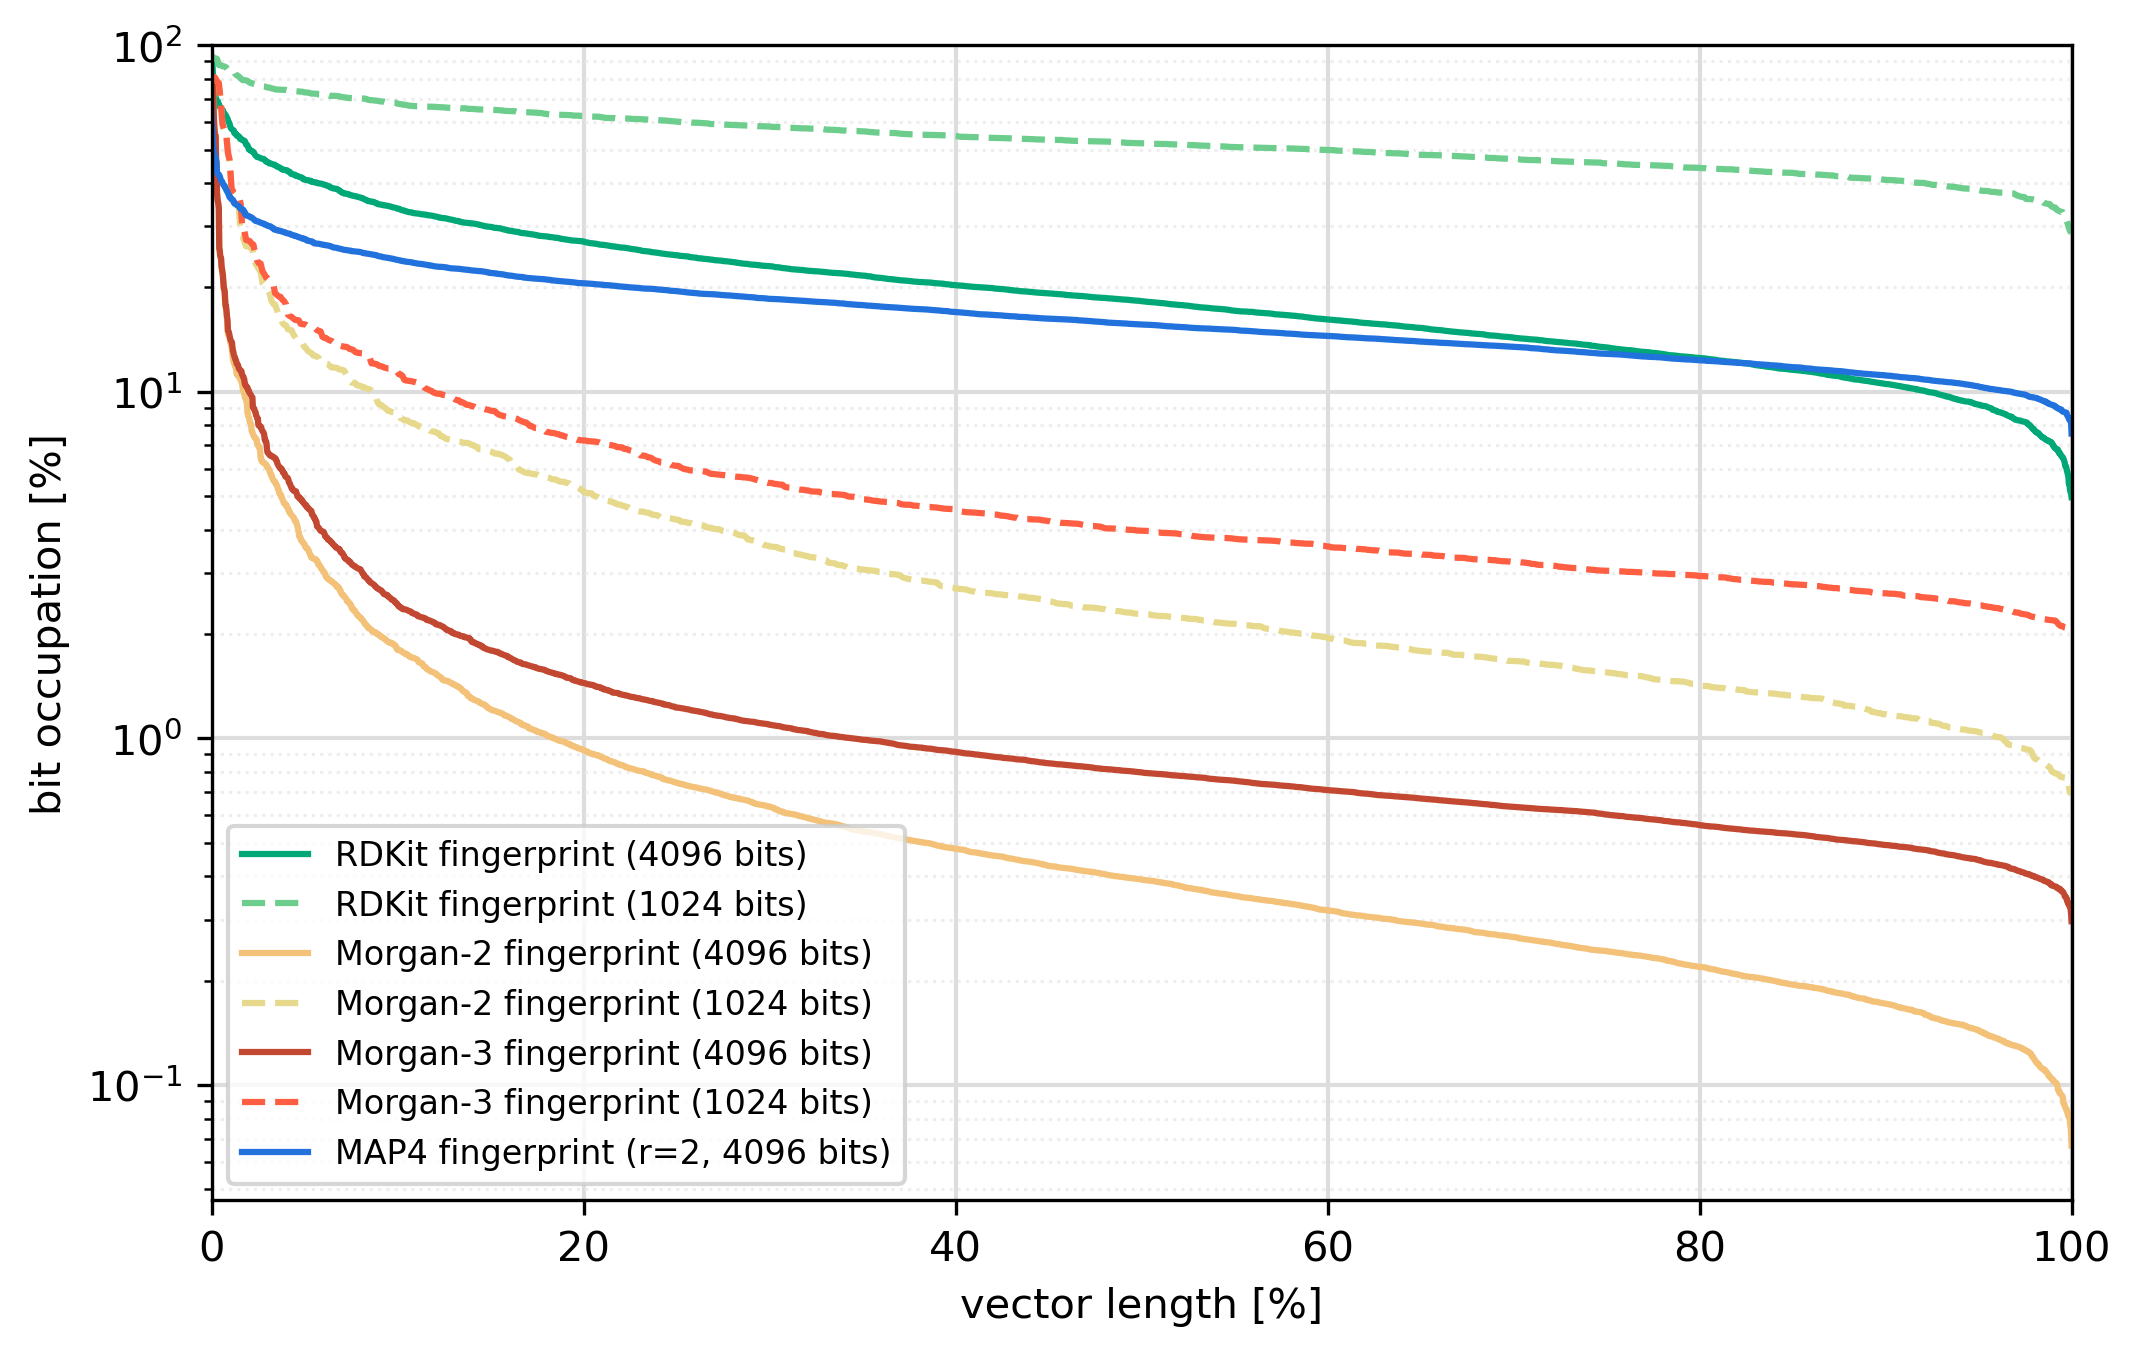

In [44]:
plt.style.use('default')


fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

fig_i = -1
for i, (file, name) in enumerate(files_experiments):
    if "count" in name:
        continue
    fig_i += 1
    bins_occupied = np.load(f"{file}_bins_occupied.npy")
    order = np.argsort(bins_occupied)[::-1]
    bins_scaled = np.linspace(0, 100, len(bins_occupied))


    if "1024" in name:
        ax.plot(bins_scaled, bins_occupied[order], "--", linewidth=1.5, color=colors[fig_i], label=name)
    else:
        ax.plot(bins_scaled, bins_occupied[order], linewidth=1.5, color=colors[fig_i], label=name)

ax.set_yscale("log")
ax.set_ylabel("bit occupation [%]")
ax.set_xlabel("vector length [%]")
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])

# Grid
ax.grid(which='major', color='#DDDDDD', linewidth=1)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)


plt.legend(fontsize=8)
plt.savefig("Bit_occupation_distributions_scaled_700k.pdf")
plt.savefig("Bit_occupation_distributions_scaled_700k.png", dpi=300)
plt.show()


In [71]:
masses = []
for smiles_string in tqdm(compounds.smiles):
    masses.append(calculate_mass(smiles_string))

masses = np.array(masses)

  0%|          | 0/718067 [00:00<?, ?it/s]

[14:52:21] WARNING: not removing hydrogen atom without neighbors
[14:52:21] WARNING: not removing hydrogen atom without neighbors
[14:52:21] WARNING: not removing hydrogen atom without neighbors


In [45]:
plt.style.use('ggplot')
#plt.style.use("fivethirtyeight")

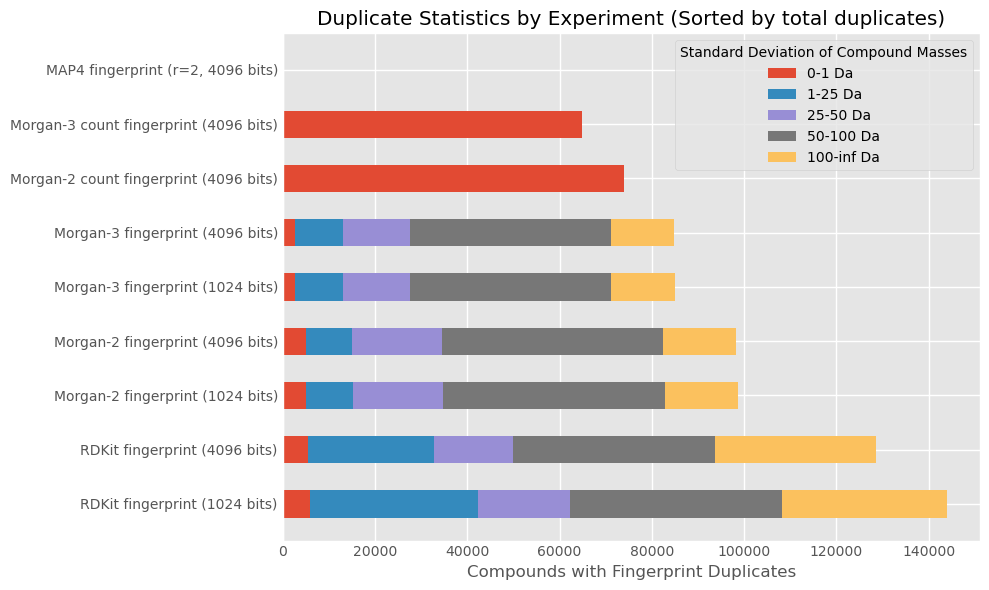

In [38]:
# Define the bins
bins = [(0, 1), (1, 25), (25, 50), (50, 100), (100, np.inf)]
bin_labels = [f"{low}-{high} Da" if high != np.inf else f"{low}-inf Da" for low, high in bins]


# Initialize results storage
experiment_sums = {name: np.zeros(len(bins)) for _, name in files_experiments}

# Process each experiment
for file, name in files_experiments:
    # Load duplicates data
    with open(f"{file}_duplicates.pickle", "rb") as f:
        duplicates = pickle.load(f)

    # Calculate statistics
    duplicate_statistics = np.array([len(x) for x in duplicates])
    duplicate_masses = [masses[i] for i in duplicates]
    max_mass_differences = np.array([x.std() for x in duplicate_masses])

    # Compute sums for each bin
    for i, (low, high) in enumerate(bins):
        idx = np.where((max_mass_differences >= low) & (max_mass_differences < high))[0]
        experiment_sums[name][i] = duplicate_statistics[idx].sum()

# Sort experiments by total sum
sorted_experiments = sorted(
    experiment_sums.items(), 
    key=lambda item: item[1].sum(), 
    reverse=True
)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare for stacked bar chart
width = 0.5
y_positions = np.arange(len(sorted_experiments))
left_stack = np.zeros(len(sorted_experiments))

# Iterate over bins and stack their sums
for i, label in enumerate(bin_labels):
    values = [experiment[1][i] for experiment in sorted_experiments]
    ax.barh(y_positions, values, width, label=label, left=left_stack)
    left_stack += values

# Configure plot appearance
ax.set_yticks(y_positions)
ax.set_yticklabels([experiment[0] for experiment in sorted_experiments])
ax.set_xlabel("Compounds with Fingerprint Duplicates")
ax.set_title("Duplicate Statistics by Experiment (Sorted by total duplicates)")
ax.legend(title="Standard Deviation of Compound Masses", loc="upper right")

plt.tight_layout()
plt.show()


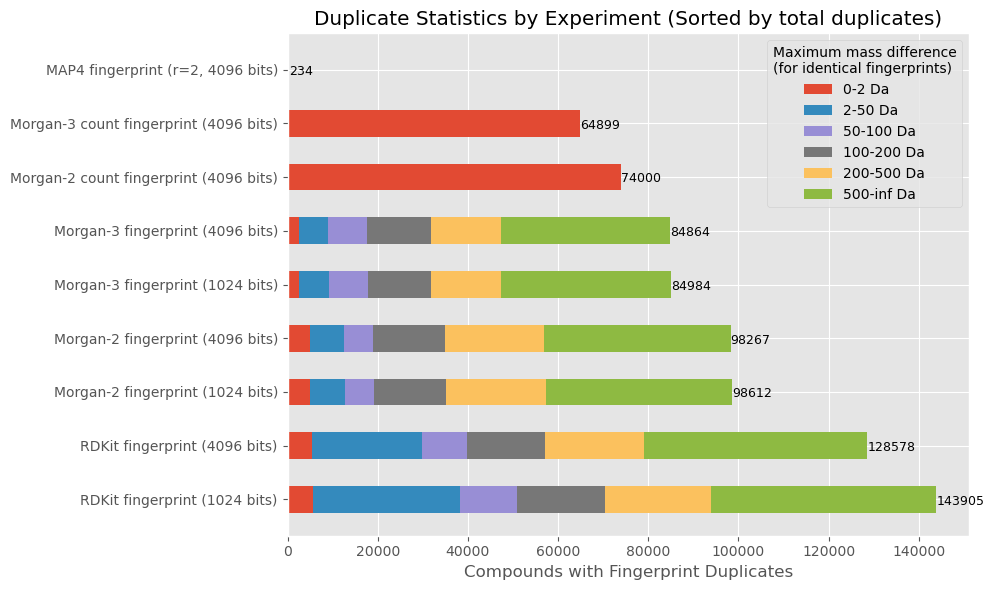

In [90]:
def max_mass_diff(masses):
    return masses.max() - masses.min()


# Define the bins
bins = [(0, 2), (2, 50), (50, 100), (100, 200), (200, 500), (500, np.inf)]
bin_labels = [f"{low}-{high} Da" if high != np.inf else f"{low}-inf Da" for low, high in bins]


# Initialize results storage
experiment_sums = {name: np.zeros(len(bins)) for _, name in files_experiments}

# Process each experiment
for file, name in files_experiments:
    # Load duplicates data
    with open(f"{file}_duplicates.pickle", "rb") as f:
        duplicates = pickle.load(f)

    # Calculate statistics
    duplicate_statistics = np.array([len(x) for x in duplicates])
    duplicate_masses = [masses[i] for i in duplicates]
    max_mass_differences = np.array([max_mass_diff(x) for x in duplicate_masses])

    # Compute sums for each bin
    for i, (low, high) in enumerate(bins):
        idx = np.where((max_mass_differences >= low) & (max_mass_differences < high))[0]
        experiment_sums[name][i] = duplicate_statistics[idx].sum()

# Sort experiments by total sum
sorted_experiments = sorted(
    experiment_sums.items(), 
    key=lambda item: item[1].sum(), 
    reverse=True
)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare for stacked bar chart
width = 0.5
y_positions = np.arange(len(sorted_experiments))
left_stack = np.zeros(len(sorted_experiments))

# Iterate over bins and stack their sums
for i, label in enumerate(bin_labels):
    values = [experiment[1][i] for experiment in sorted_experiments]
    ax.barh(y_positions, values, width, label=label, left=left_stack)
    left_stack += values

# Add numbers
for i, y in enumerate(y_positions):
    value = sorted_experiments[i][1].sum()
    plt.text(value, i-0.1, f"{value:.0f}", fontsize=9)

# Configure plot appearance
ax.set_yticks(y_positions)
ax.set_yticklabels([experiment[0] for experiment in sorted_experiments])
ax.set_xlabel("Compounds with Fingerprint Duplicates")
ax.set_title("Duplicate Statistics by Experiment (Sorted by total duplicates)")
ax.legend(title="Maximum mass difference\n(for identical fingerprints)", loc="upper right")

plt.tight_layout()
plt.savefig("Duplicate_statistics_max_mass_difference_700k.pdf")
plt.savefig("Duplicate_statistics_max_mass_difference_700k.png", dpi=300)
plt.show()
